In [1]:
# This notebook serves as an experiment for 1. creating a tabular dataset for a simple game, and 2. creating a custom RL gym environment for the game.

In [1]:
# import packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import itertools


In [ ]:
# create function and create dataset

def generate_enhanced_rl_dataset_v5(num_worlds=6):
    # Generate all possible combinations of three capital letters
    all_possible_ids = [''.join(combination) for combination in itertools.product(string.ascii_uppercase, repeat=3)]
    # Randomly select 50 unique car IDs from the possible combinations
    selected_car_ids = np.random.choice(all_possible_ids, size=50, replace=False)
    
    # Generate team IDs
    teams = [''.join(np.random.choice(list(string.ascii_uppercase), size=4)) for _ in range(10)]
    team_strategies = np.random.choice(['passive', 'normal', 'aggressive'], size=10)
    team_mapping = dict(zip(teams, team_strategies))
    
    # Generate driver IDs and their experience levels
    driver_ids = ['D' + str(i).zfill(2) for i in range(1, 26)]
    driver_experience = np.random.choice(['high', 'low', 'no experience'], size=25)
    driver_mapping = dict(zip(driver_ids, driver_experience))
    
    # Distribute cars among teams ensuring at least 3 cars per team
    min_cars_per_team = 3
    cars_for_teams = np.repeat(teams, min_cars_per_team).tolist()  # 30 cars assigned
    remaining_cars = 50 - len(cars_for_teams)
    cars_for_teams.extend(np.random.choice(teams, remaining_cars).tolist())
    
    # Assign drivers to cars
    driver_assignments = np.repeat(driver_ids, 2).tolist()  # Each driver drives 2 cars
    
    # Shuffle the team assignments and driver assignments for randomness
    np.random.shuffle(cars_for_teams)
    np.random.shuffle(driver_assignments)
    
    # Initialize the dataframe
    rl_df = pd.DataFrame(columns=['World', 'Level', 'Car_ID', 'Odds', 'car_last3r', 'Race_Winner', 
                                  'Team_ID', 'Team_Strategy', 'Driver_ID', 'Driver_Experience', 'driver_last3r', 'Car_Speed'])
    
    for world in range(1, num_worlds + 1):
        num_levels = np.random.randint(3, 6)
        
        for level in range(1, num_levels + 1):
            num_cars = np.random.randint(4, 11)
            cars_in_race = np.random.choice(selected_car_ids, size=num_cars, replace=False)
            drivers_in_race = np.random.choice(driver_ids, size=num_cars, replace=True)
            odds = np.random.randint(1, 15, size=num_cars)
            car_speeds = np.random.randint(50, 101, size=num_cars)
            
            # Compute last3r values and probabilities for winning based on various factors
            car_last3r = []
            driver_last3r = []
            winning_probs = []
            
            for i, (car_id, driver_id) in enumerate(zip(cars_in_race, drivers_in_race)):
                car_previous_races = rl_df[rl_df['Car_ID'] == car_id]['Race_Winner'].tail(3)
                car_last3r_value = car_previous_races.map({'Yes': 1, 'No': 0}).sum()
                car_last3r.append(car_last3r_value)

                driver_previous_races = rl_df[rl_df['Driver_ID'] == driver_id]['Race_Winner'].tail(3)
                driver_last3r_value = driver_previous_races.map({'Yes': 1, 'No': 0}).sum()
                driver_last3r.append(driver_last3r_value)
                
                # Adjusting the probability based on speed, team strategy, and driver experience as well as odds and last3r
                speed_factor = car_speeds[i] / 100
                strategy_factor = 1 if team_mapping[cars_for_teams[i]] == 'aggressive' else (0.7 if team_mapping[cars_for_teams[i]] == 'normal' else 0.5)
                experience_factor = 1 if driver_mapping[driver_assignments[i]] == 'high' else (0.7 if driver_mapping[driver_assignments[i]] == 'low' else 0.5)
                
                inverse_odds = 1 / odds[i]
                odds_last3r_factor = (inverse_odds + (car_last3r_value / 3) + (driver_last3r_value / 3)) / 2

                # Calculate the winning probability
                winning_prob = speed_factor * strategy_factor * experience_factor * odds_last3r_factor
                winning_probs.append(winning_prob)
            
            # Normalize the winning probabilities to sum to 1
            winning_probs = np.array(winning_probs) / sum(winning_probs)
            
            # Decide the race winner based on calculated probabilities
            winner_index = np.random.choice(num_cars, p=winning_probs)
            
            for i, (car_id, driver_id) in enumerate(zip(cars_in_race, drivers_in_race)):
                race_winner = "Yes" if i == winner_index else "No"
                rl_df.loc[len(rl_df)] = [world, level, car_id, odds[i], car_last3r[i], race_winner, 
                                         cars_for_teams[i], team_mapping[cars_for_teams[i]], 
                                         driver_id, driver_mapping[driver_id], driver_last3r[i], car_speeds[i]]
    
    return rl_df



In [23]:
# Generate a sample dataset using the enhanced function
rl_dataset = generate_enhanced_rl_dataset_v5(100)
rl_dataset.head(10)

,World,Level,Car_ID,Odds,car_last3r,Race_Winner,Team_ID,Team_Strategy,Driver_ID,Driver_Experience,driver_last3r,Car_Speed
0,1,1,PPU,9,0,No,AAPK,aggressive,D08,high,0,73
1,1,1,UWQ,6,0,No,UALO,normal,D05,high,0,59
2,1,1,CGA,6,0,No,GDZL,passive,D10,no experience,0,81
3,1,1,WGL,13,0,No,MVTK,normal,D17,low,0,75
4,1,1,MSN,4,0,No,AAPK,aggressive,D14,high,0,79
5,1,1,AQT,2,0,No,MVTK,normal,D01,no experience,0,65
6,1,1,IFQ,9,0,No,AAPK,aggressive,D09,no experience,0,57
7,1,1,OYD,13,0,No,KLWF,normal,D08,high,0,63
8,1,1,WMS,6,0,Yes,AAPK,aggressive,D15,high,0,65
9,1,1,LAK,14,0,No,CLWQ,passive,D20,low,0,57


In [24]:
# look at a race in a level in a world

rl_dataset[(rl_dataset['World'] == 50) & (rl_dataset['Level'] == 3)]

,World,Level,Car_ID,Odds,car_last3r,Race_Winner,Team_ID,Team_Strategy,Driver_ID,Driver_Experience,driver_last3r,Car_Speed
1432,50,3,WGL,10,0,No,AAPK,aggressive,D07,high,0,84
1433,50,3,UWQ,9,0,No,UALO,normal,D06,low,2,86
1434,50,3,ZWO,2,0,No,GDZL,passive,D22,low,0,95
1435,50,3,EKP,14,0,No,MVTK,normal,D21,low,0,71
1436,50,3,AQT,1,0,No,AAPK,aggressive,D17,low,1,77
1437,50,3,SED,3,1,No,MVTK,normal,D25,low,1,97
1438,50,3,HNL,2,1,Yes,AAPK,aggressive,D21,low,0,91


/home/nilllas/RL_CustomGymEnvCars/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nilllas/RL_CustomGymEnvCars/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nilllas/RL_CustomGymEnvCars/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nilllas/RL_CustomGymEnvCars/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

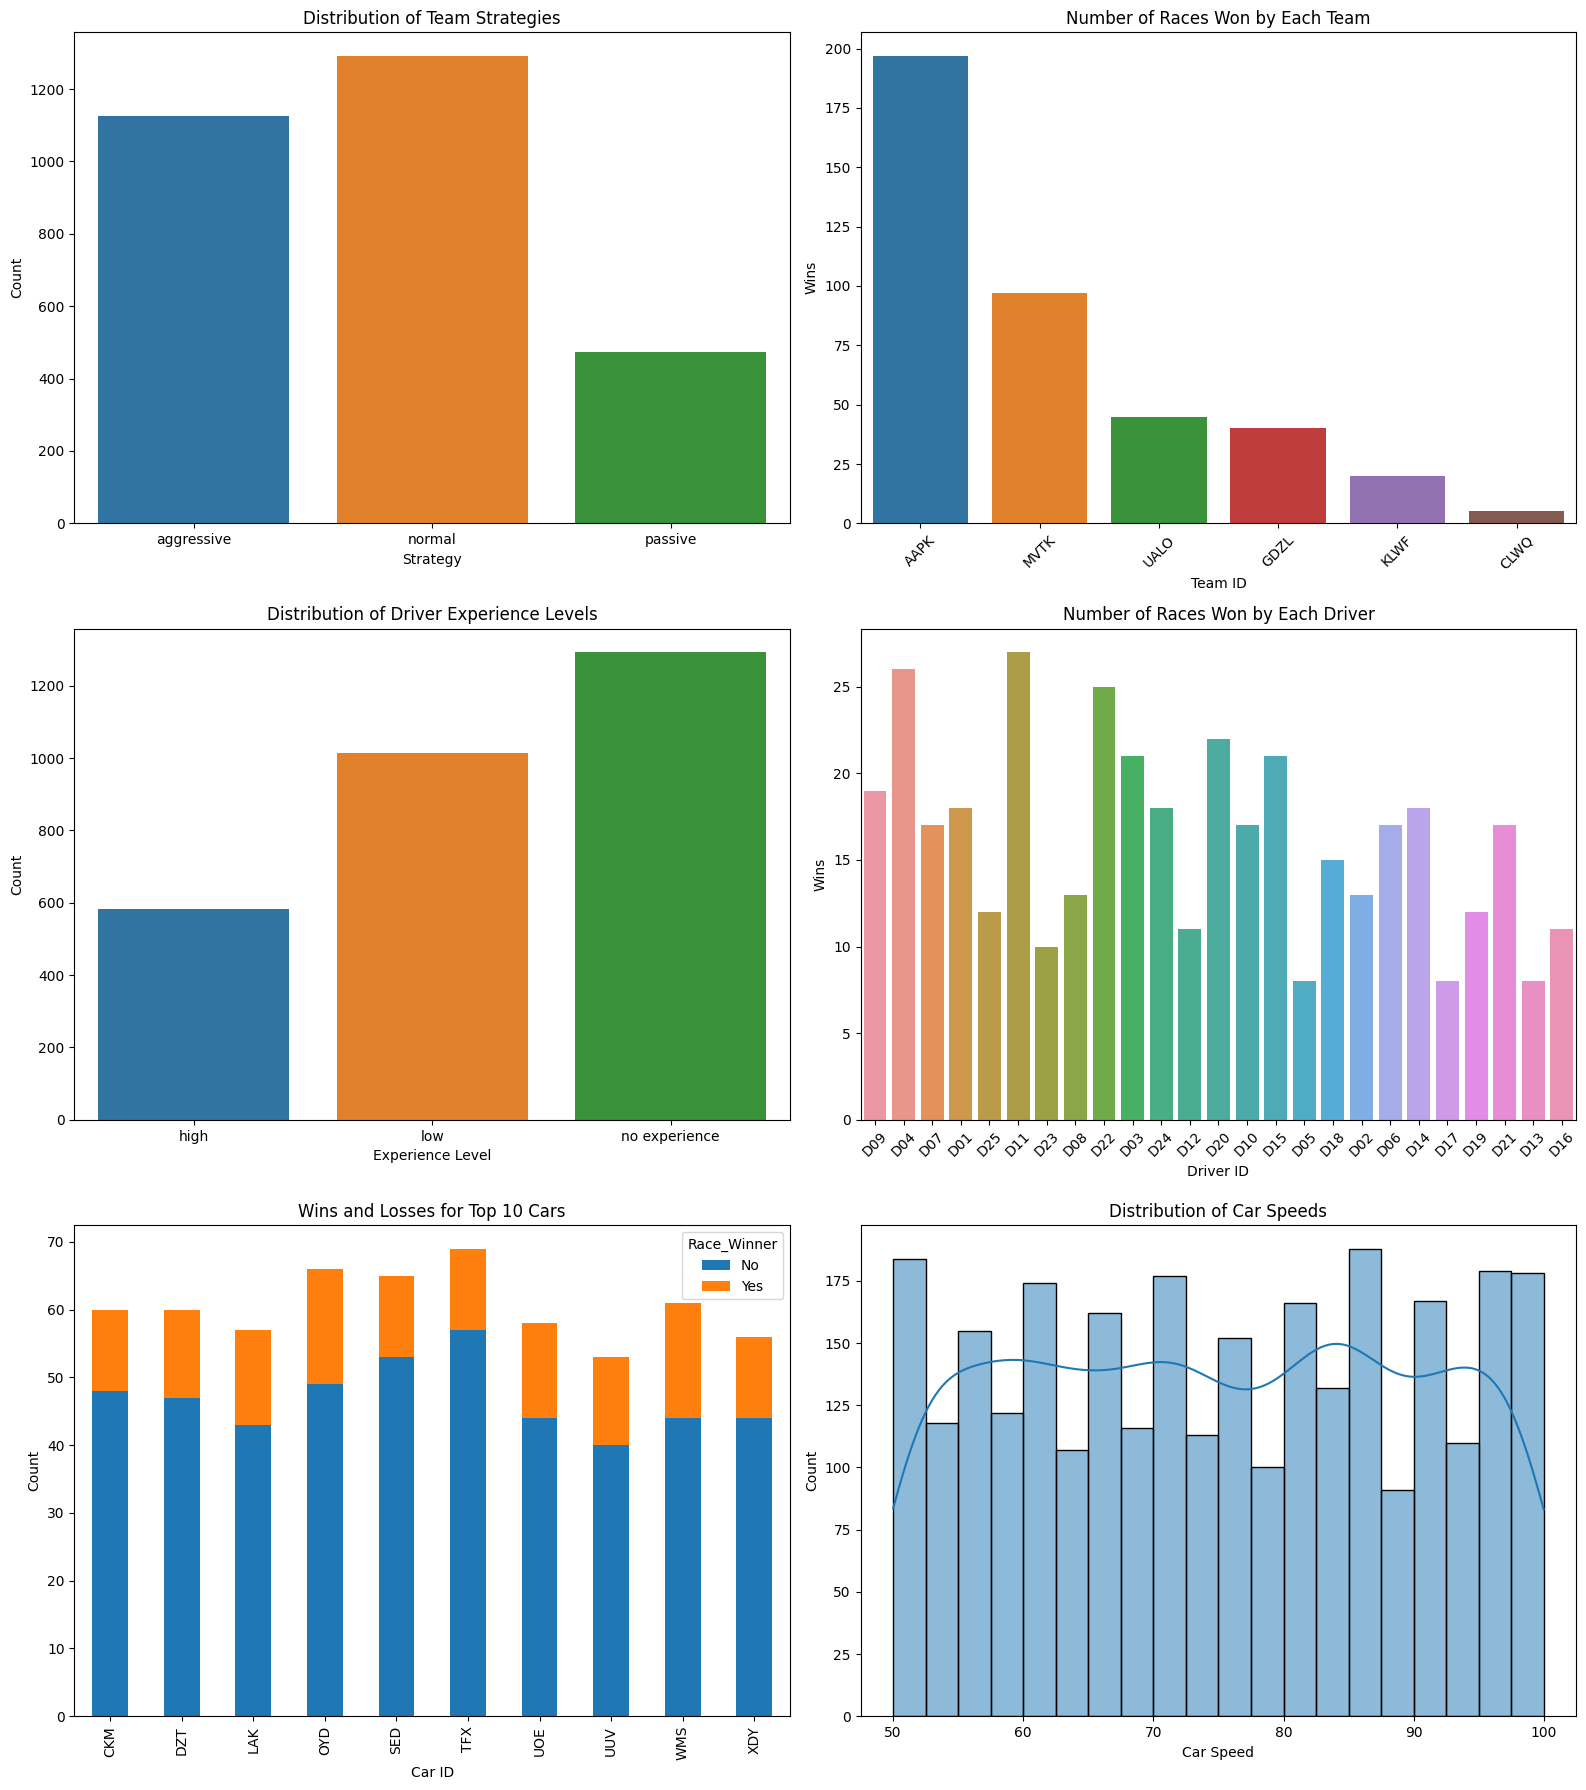

In [25]:


# Set up the figure and axes
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))

# 1. For Teams:

# Distribution of different strategies among teams.
sns.countplot(data=rl_dataset, x='Team_Strategy', ax=axs[0, 0])
axs[0, 0].set_title("Distribution of Team Strategies")
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_xlabel("Strategy")

# Number of races won by each team.
sns.countplot(data=rl_dataset[rl_dataset['Race_Winner'] == 'Yes'], x='Team_ID', order=rl_dataset['Team_ID'].value_counts().index, ax=axs[0, 1])
axs[0, 1].set_title("Number of Races Won by Each Team")
axs[0, 1].set_ylabel("Wins")
axs[0, 1].set_xlabel("Team ID")
axs[0, 1].tick_params(axis='x', rotation=45)

# 2. For Drivers:

# Distribution of experience levels among drivers.
sns.countplot(data=rl_dataset, x='Driver_Experience', order=['high', 'low', 'no experience'], ax=axs[1, 0])
axs[1, 0].set_title("Distribution of Driver Experience Levels")
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_xlabel("Experience Level")

# Number of races won by each driver.
sns.countplot(data=rl_dataset[rl_dataset['Race_Winner'] == 'Yes'], x='Driver_ID', order=rl_dataset['Driver_ID'].value_counts().index, ax=axs[1, 1])
axs[1, 1].set_title("Number of Races Won by Each Driver")
axs[1, 1].set_ylabel("Wins")
axs[1, 1].set_xlabel("Driver ID")
axs[1, 1].tick_params(axis='x', rotation=45)

# 3. For Cars:

# Distribution of wins and losses for the top 10 cars.
top_cars = rl_dataset[rl_dataset['Race_Winner'] == 'Yes']['Car_ID'].value_counts().head(10).index
car_wins_losses = rl_dataset[rl_dataset['Car_ID'].isin(top_cars)].groupby(['Car_ID', 'Race_Winner']).size().unstack()
car_wins_losses.plot(kind='bar', stacked=True, ax=axs[2, 0])
axs[2, 0].set_title("Wins and Losses for Top 10 Cars")
axs[2, 0].set_ylabel("Count")
axs[2, 0].set_xlabel("Car ID")

# Distribution of average car speeds.
sns.histplot(rl_dataset['Car_Speed'], bins=20, kde=True, ax=axs[2, 1])
axs[2, 1].set_title("Distribution of Car Speeds")
axs[2, 1].set_ylabel("Count")
axs[2, 1].set_xlabel("Car Speed")

# Adjust layout
plt.tight_layout()
plt.show()


/home/nilllas/RL_CustomGymEnvCars/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nilllas/RL_CustomGymEnvCars/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/nilllas/RL_CustomGymEnvCars/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nilllas/RL_CustomGymEnvCars/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated

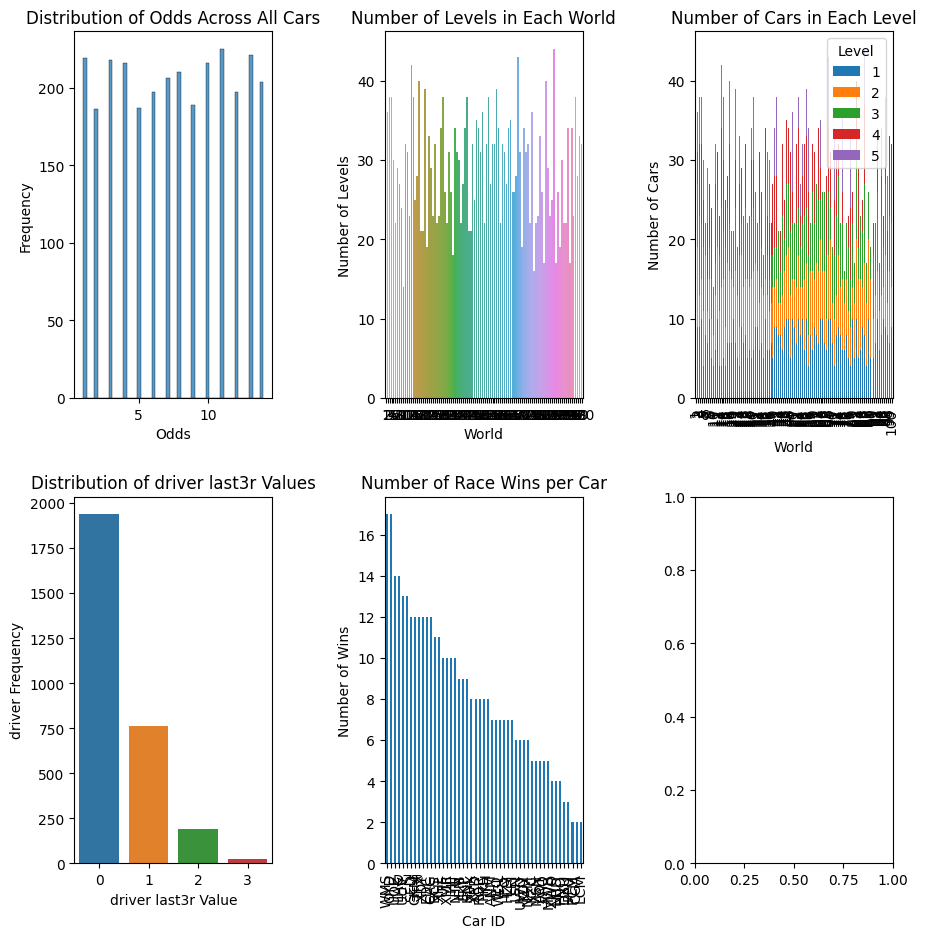

In [30]:


# Set up the subplots for visualizations
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
fig.tight_layout(pad=5.0)

# 1. Distribution of odds across all cars
sns.histplot(rl_dataset['Odds'], bins=50, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Odds Across All Cars')
axes[0, 0].set_xlabel('Odds')
axes[0, 0].set_ylabel('Frequency')

# 2. Number of levels in each world
sns.countplot(data=rl_dataset, x='World', ax=axes[0, 1])
axes[0, 1].set_title('Number of Levels in Each World')
axes[0, 1].set_xlabel('World')
axes[0, 1].set_ylabel('Number of Levels')

# 3. Number of cars in each level
rl_dataset.groupby(['World', 'Level']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0, 2])
axes[0, 2].set_title('Number of Cars in Each Level')
axes[0, 2].set_xlabel('World')
axes[0, 2].set_ylabel('Number of Cars')

# 4. Distribution of last3r values across all cars
sns.countplot(data=rl_dataset, x='car_last3r', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of car last3r Values')
axes[1, 0].set_xlabel('car last3r Value')
axes[1, 0].set_ylabel('car Frequency')

# 5. Distribution of last3r values across all cars
sns.countplot(data=rl_dataset, x='driver_last3r', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of driver last3r Values')
axes[1, 0].set_xlabel('driver last3r Value')
axes[1, 0].set_ylabel('driver Frequency')

# 6. Number of race wins per car
car_wins = rl_dataset[rl_dataset['Race_Winner'] == 'Yes']['Car_ID'].value_counts()
car_wins.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Number of Race Wins per Car')
axes[1, 1].set_xlabel('Car ID')
axes[1, 1].set_ylabel('Number of Wins')



plt.show()


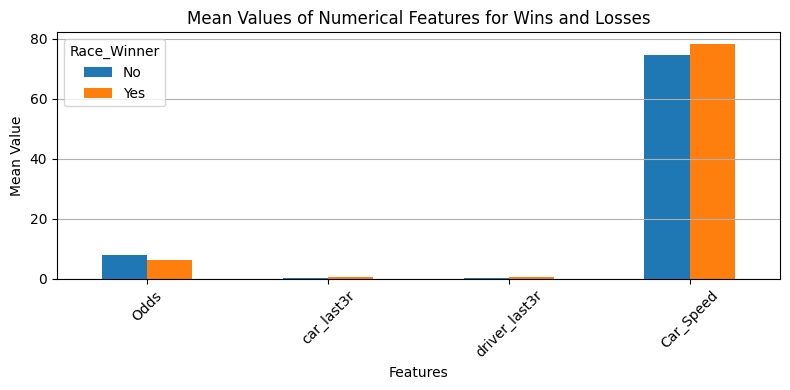

In [34]:
# Convert the 'Race_Winner' column to numerical values for easier calculations: Yes -> 1, No -> 0
rl_dataset['Race_Winner_Num'] = rl_dataset['Race_Winner'].map({'Yes': 1, 'No': 0})

# List of numerical columns to investigate
num_cols = ['Odds', 'car_last3r', 'driver_last3r', 'Car_Speed']

# Calculate mean values for each numerical feature grouped by 'Race_Winner'
mean_values = rl_dataset.groupby('Race_Winner')[num_cols].mean()

# Plot the mean values for wins and losses
mean_values.T.plot(kind='bar', figsize=(8, 4))
plt.title("Mean Values of Numerical Features for Wins and Losses")
plt.ylabel("Mean Value")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

plt.show()

/home/nilllas/RL_CustomGymEnvCars/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nilllas/RL_CustomGymEnvCars/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nilllas/RL_CustomGymEnvCars/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nilllas/RL_CustomGymEnvCars/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

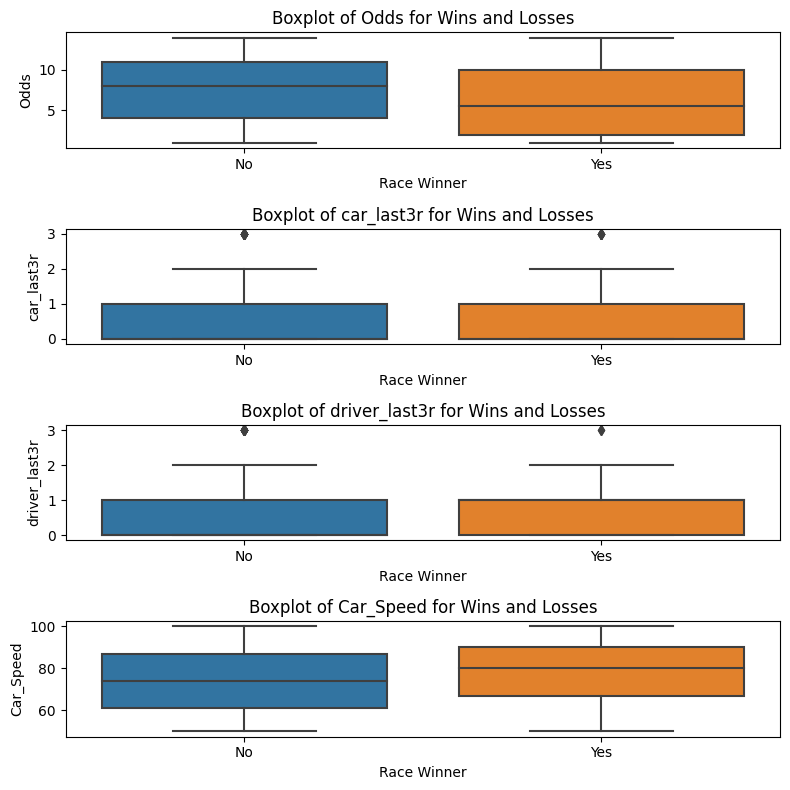

In [33]:
# Visualizing the mean values for wins and losses using a different method
fig, axs = plt.subplots(len(num_cols), 1, figsize=(8, 8))

for i, col in enumerate(num_cols):
    sns.boxplot(data=rl_dataset, x='Race_Winner', y=col, ax=axs[i])
    axs[i].set_title(f"Boxplot of {col} for Wins and Losses")
    axs[i].set_ylabel(col)
    axs[i].set_xlabel("Race Winner")

plt.tight_layout()
plt.show()

In [38]:
from scipy.stats import chi2_contingency

# List of categorical columns to investigate
cat_cols = ['Team_Strategy', 'Driver_Experience','car_last3r', 'driver_last3r', 'Car_Speed']

# Store p-values for each categorical feature
p_values = {}

for col in cat_cols:
    # Create a contingency table
    contingency_table = pd.crosstab(rl_dataset['Race_Winner'], rl_dataset[col])
    
    # Perform chi-squared test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    p_values[col] = p

p_values

{'Team_Strategy': 1.8120199276687958e-05,
 'Driver_Experience': 0.8074990247430383,
 'car_last3r': 1.6533314679307301e-10,
 'driver_last3r': 1.762188277211325e-14,
 'Car_Speed': 0.009523928851680914}